# Comparing fmriprep with fslfeat: group analysis results

In [1]:
from nipype.algorithms.metrics import FuzzyOverlap
from nilearn.image import resample_to_img
from scipy.stats import pearsonr
from __future__ import division
import matplotlib.pyplot as plt
from collections import Counter
from nilearn import plotting
import nibabel as nib
import seaborn as sns
import pandas as pd
import numpy as np
import palettable
import json
import sys
import os

sys.path.append(os.path.join(os.environ.get("HOME"),"CNP_analysis"))
from utils import get_config, atlas
from utils.prog import log_progress as lp

%matplotlib inline

sns.set_style('white')

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

sns.set_palette(palettable.tableau.ColorBlind_10.mpl_colors)

/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pipelines= ['fmriprep-1.0.3','fslfeat_5.0.9']

In [3]:
basedir = os.path.join(os.environ.get("PREPBASEDIR"),"fmriprep_vs_feat")

# Example: 1 (random) group analysis

In [4]:
samplesize = 50
experiment = np.random.choice(range(0,100))
sample = 0

zstatfile = {}
pstatfile = {}
tstat = {}

for pipeline in pipelines:
    zfile = os.path.join(basedir,pipeline,'task_group/samplesize_%i/experiment_%i/stopsignal'%(samplesize,experiment),
                                         'sample_%i/cope11/OLS/zstat1.nii.gz'%sample)
    zstatfile[pipeline]=zfile
    pfile = os.path.join(basedir,pipeline,'task_group/samplesize_%i/experiment_%i/stopsignal'%(samplesize,experiment),
                                         'sample_%i/cope11/OLS/pstat1.nii.gz'%sample)
    pstatfile[pipeline]=pfile
    tstat[pipeline]=nib.load(tfile).get_data()


### T distributions of example group study ( n = 50 )

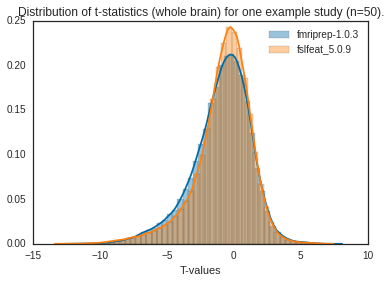

In [5]:
for pipeline in pipelines:
    ts = zstat[pipeline]
    sns.distplot(ts[ts!=0],label=pipeline)

plt.title("Distribution of t-statistics (whole brain) for one example study (n=50).")
plt.xlabel("T-values")
plt.legend()

/share/PI/russpold/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


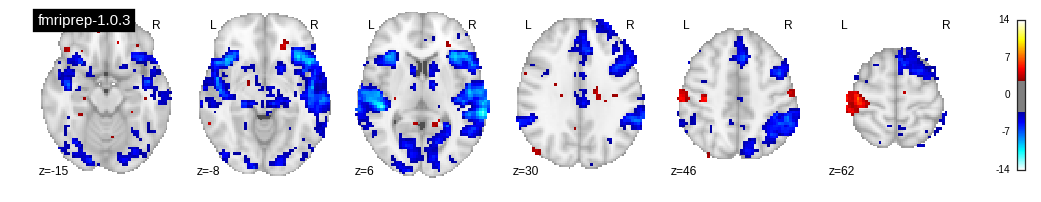

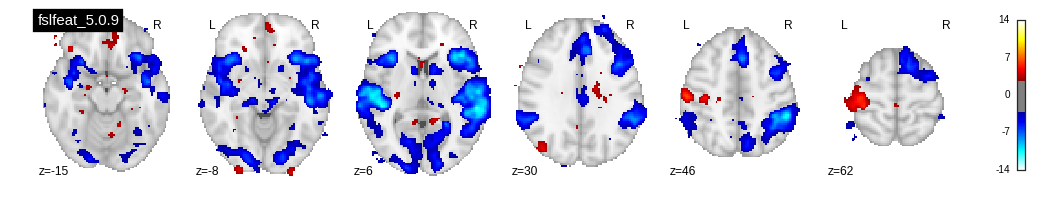

In [6]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for pipeline in pipelines:
    ts = zstatfile[pipeline]
    plotting.plot_stat_map(ts,title=pipeline,threshold=2.98,display_mode='z',cut_coords=cut_coords,vmax=14)
plotting.show()

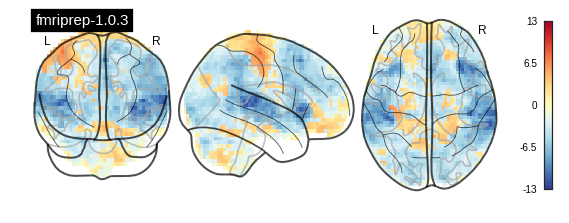

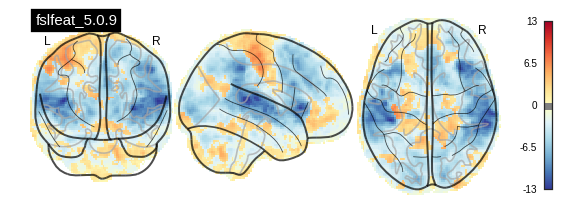

In [7]:
for pipeline in pipelines:
    ts = tstatfile[pipeline]
    plotting.plot_glass_brain(ts,title=pipeline,cmap='RdYlBu_r',
                              vmax = 13,colorbar=True,symmetric_cbar=True,plot_abs=False)
plotting.show()

# Atlases and effect sizes in regions

Below we show how we analyse the effect size in our regions of interest.  The regions of interest are:
- Purple: the Subthalamic Nucleus (STN)
- Yellow: the Inferior Frontal Gyrus (IFG)
- Blue: the pre-Supplementary Motor Area (preSMA)
- Red: the Precentral Gyrus (PCG)

In [8]:
atlas,labels = atlas.create_atlas()

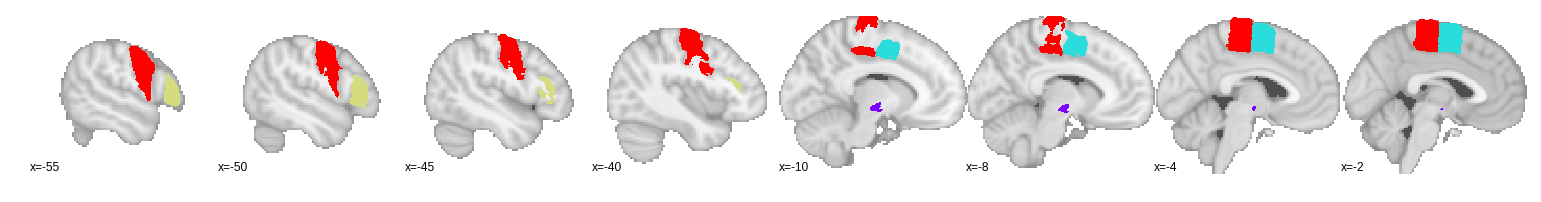

In [9]:
cut_coords = [-2,-4,-8,-10,-40,-45,-50,-55]
plotting.plot_roi(atlas,display_mode='x',cut_coords=cut_coords,cmap='rainbow',alpha=1)

This is the example above, but in the same view as the atlas shown above.  You can see negative effects in the STN, IFG and positive effect in the motor area.  Note that this is only the left hemisphere, and as you can see above, the motor response is only on the left hemisphere (indicating that the motor response was given with the right hand).  However, in the analyses below, we look at the average response **in both hemispheres**.  We might change that?

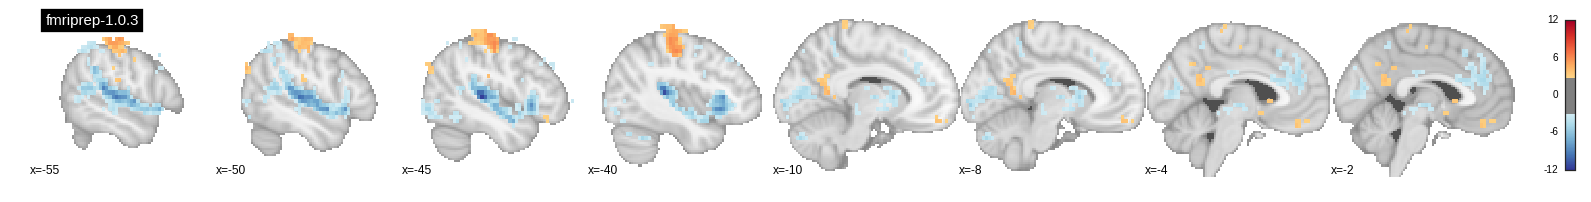

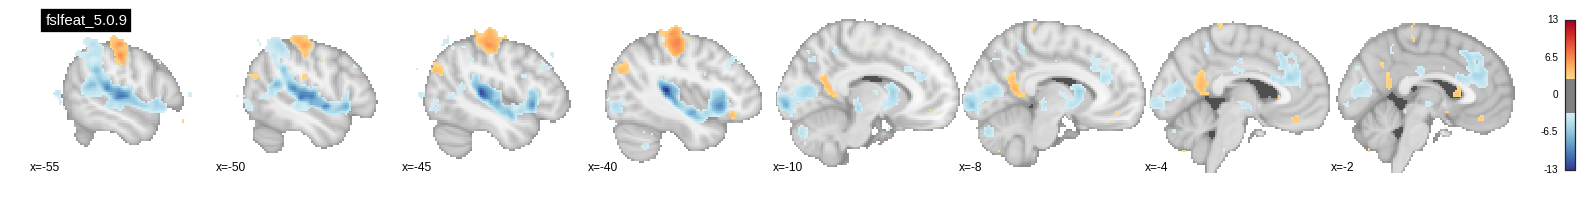

In [10]:
cut_coords = [-2,-4,-8,-10,-40,-45,-50,-55]
for pipeline in pipelines:
    ts = zstatfile[pipeline]
    plotting.plot_stat_map(ts,display_mode='x',cut_coords=cut_coords,cmap='RdYlBu_r',
                       alpha=1,threshold=2.98,title=pipeline)

In [11]:
ES = {}
for pipeline in pipelines:
    ts = zstatfile[pipeline]
    atlas_resampled = resample_to_img(atlas,ts,interpolation='nearest')
    dat = atlas_resampled.get_data()
    ES[pipeline] = {}
    for k,v in labels.iteritems():
        indxs = np.where(dat==k)
        T = nib.load(tfile).get_data()[indxs]
        CD = np.mean(T)/np.sqrt(samplesize)
        ES[pipeline][v] = CD

Below is a table with the effect sizes estimates for this particular example.  We will repeat this analysis for all experiments below.

In [12]:
pd.DataFrame(ES)

,fmriprep-1.0.3,fslfeat_5.0.9
IFG,-0.117676,-0.262066
PCG,-0.050599,0.060563
STN,-0.167826,-0.257897
preSMA,0.065751,0.051350


# Test-retest replicability for different sample sizes

We can now take a look at the distribution of effect sizes in all experiment (100 x 2 samples = 200 group studies).  Note though that the studies **are not** independent and reflect activation from the same 200-and-something subjects...

## Effect size estimations

In [13]:
results = pd.read_csv(os.path.join(basedir,"results.csv"),index_col=0)
results['samplesize'] = [int(x) for x in results['samplesize']]

with open(os.path.join(basedir,"tvals.json")) as json_data:
    allT = json.load(json_data)
    json_data.close()

In [14]:
results.head()

,IFG,PCG,STN,correlation,dice,experiment,fdice,pipeline,preSMA,samplesize
0,-0.178780,0.047879,-0.347886,0.406963,NaN,1,0.936810,fmriprep-1.0.3,0.187530,10
1,-0.018633,-0.008061,-0.307840,0.420029,NaN,2,0.938833,fmriprep-1.0.3,0.067271,10
2,-0.319850,-0.140962,-0.478731,0.507892,NaN,3,0.941225,fmriprep-1.0.3,-0.420609,10
3,0.084494,0.040409,-0.327683,0.368946,NaN,4,0.937903,fmriprep-1.0.3,0.065498,10
4,-0.512003,-0.153870,-0.095368,0.444201,NaN,5,0.944980,fmriprep-1.0.3,-0.169115,10


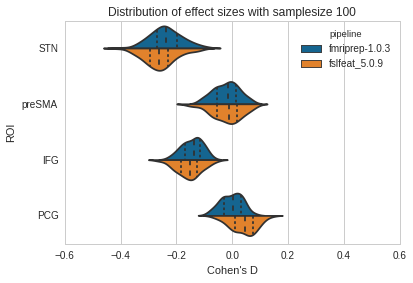

In [15]:
samplesize = 90
reslong = pd.melt(results,id_vars=['pipeline','samplesize'],
                  value_vars=labels.values(),var_name="ROI",value_name="Cohen's D")

def ESfigure(reslong,samplesize,xlim=[-0.6,0.6]):
    sns.set_style("whitegrid")
    sns.violinplot(x="Cohen's D",y='ROI',hue='pipeline',data=reslong[reslong.samplesize==samplesize],
                   split=True,inner='quartile')
    plt.title("Distribution of effect sizes with samplesize %i"%samplesize)
    plt.xlim(xlim)

ESfigure(reslong,100)

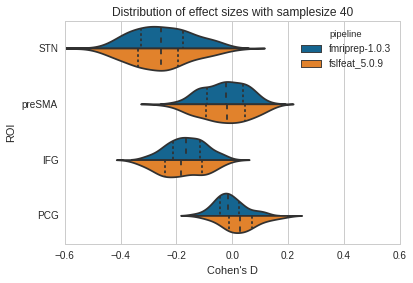

In [16]:
ESfigure(reslong,40)

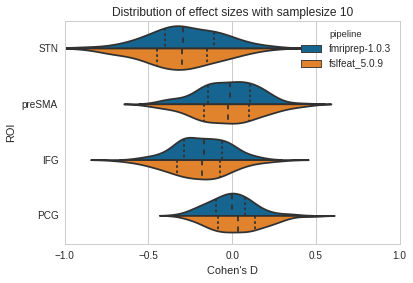

In [17]:
ESfigure(reslong,10,xlim=[-1,1])

## Metrics of overlap

**Oscar: It would be so cool if we would extend beyond 100 subjects, until we reach the plateau for dice, because it looks like the plateau will be higher...**

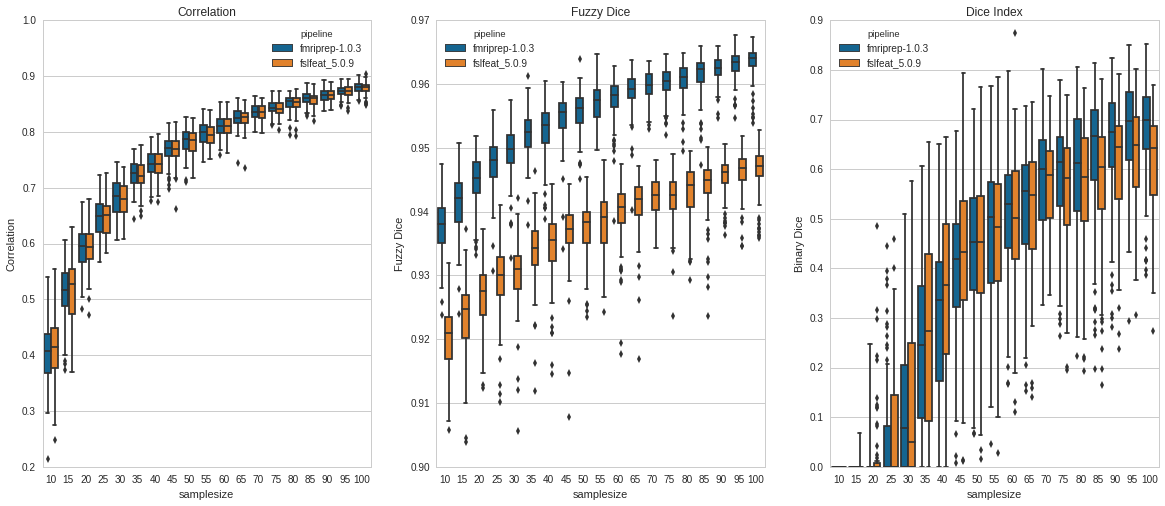

In [18]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(20,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
sns.boxplot(x="samplesize", y="correlation", hue="pipeline", data=results)
plt.ylabel("Correlation")
plt.title("Correlation")
plt.subplot(1,3,2)
sns.boxplot(x="samplesize", y="fdice", hue="pipeline", data=results)
plt.ylabel("Fuzzy Dice")
plt.title("Fuzzy Dice")
plt.subplot(1,3,3)
sns.boxplot(x="samplesize", y="dice", hue="pipeline", data=results)
plt.title("Dice Index")
plt.ylabel("Binary Dice")

## Distributions of statistical values

As with the single subject results, wider tails indicate higher power.  Due to the large number of analyses, we selected at random in each analysis 100 T-values, resulting in 9900 **NOTE TO SELF: WHY NOT 10000?** T-values reflecting the average distribution of T-values in these images.

Here we see that - however small the effect is - the power is somewhat higher with fmriprep.

In [19]:
len(allT[pipeline]['10'])

9900

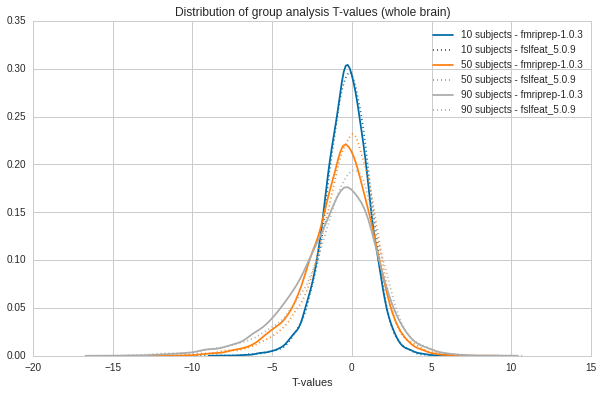

In [20]:
fig = plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')

for idx,samplesize in enumerate(np.arange(10,101,40).tolist()):
    for idy,pipeline in enumerate(pipelines):
        if idy==0:
            lsty = '-'
        else:
            lsty = ':'
        sns.distplot(allT[pipeline][str(samplesize)],color=cols[idx],hist=False,
                     kde_kws={"linestyle": lsty},label="%i subjects - %s"%(samplesize,pipeline))

plt.title("Distribution of group analysis T-values (whole brain)")
plt.xlabel("T-values")
plt.legend()

# Smoothness

In [24]:
groupfile = os.path.join(basedir,'smoothness_group.csv')
group = pd.read_csv(groupfile)
group.head()

,Unnamed: 0,FWHM_resid,FWHM_zstat,experiment,pipeline,samplesize
0,0,1.921624,2.174189,1,fmriprep-1.0.3,10
1,1,1.974198,2.642540,1,fmriprep-1.0.3,10
2,2,1.892732,2.238137,2,fmriprep-1.0.3,10
3,3,1.869824,2.446400,2,fmriprep-1.0.3,10
4,4,1.937982,2.586264,3,fmriprep-1.0.3,10


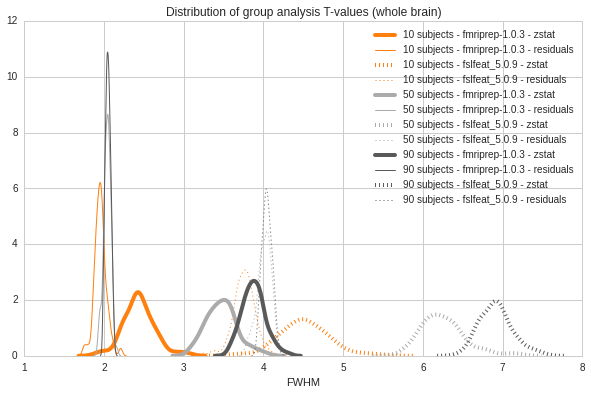

In [22]:
fig = plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
for idx,samplesize in enumerate(np.arange(10,101,40).tolist()):
    for idy,pipeline in enumerate(pipelines):
        if idy==0:
            lsty = '-'
        else:
            lsty = ':'
        subset = group[np.logical_and(group.pipeline==pipeline, group.samplesize==samplesize)]
        sns.distplot(subset.FWHM_zstat,color=cols[idx+1],hist=False,
                     kde_kws={"linestyle": lsty,"linewidth":4},label="%i subjects - %s - zstat"%(samplesize,pipeline))
        sns.distplot(subset.FWHM_resid,color=cols[idx+1],hist=False,
                     kde_kws={"linestyle": lsty,"linewidth":1},label="%i subjects - %s - residuals"%(samplesize,pipeline))

plt.title("Distribution of group analysis T-values (whole brain)")
plt.xlabel("FWHM")
plt.legend()